**We have the task of predicting which subject a set of abstract and Title belong to. It is a multi-label classification problem - so each abstract can belong to multiple subjects**

**We explore 2 approaches:**
1. **Shallow Learning using GloVe embeddings**
2. **Deep Learning using GloVe embeddings**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing, linear_model, ensemble, metrics, model_selection, svm, pipeline, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import nltk
import spacy
import textblob
#from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from sklearn.multioutput import MultiOutputClassifier
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from sklearn import decomposition
from nltk.corpus import stopwords 
sw = stopwords.words("english")
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/test.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/train.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/sample_submission_UVKGLZE.csv


In [2]:
# Read Data
train = pd.read_csv('/kaggle/input/janatahack-independence-day-2020-ml-hackathon/train.csv')
test = pd.read_csv('/kaggle/input/janatahack-independence-day-2020-ml-hackathon/test.csv')


In [3]:
# Dimensionality of embedding
n = 200

In [4]:
file = open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt', 'r')
raw = file.read()
print('Read Raw File')

# Get Embeddings in List of Lists format
emb_list = [val.split(' ') for val in raw.split('\n')]
print('Read as List of Lists')

# Convert Embeddings to dataframe format
emb = pd.DataFrame(emb_list).T
emb.columns = emb.iloc[0, :]
emb = emb.drop(0, axis = 0).astype(float)
print('Embeddings converted to DataFrame')

Read Raw File
Read as List of Lists
Embeddings converted to DataFrame


## Shallow Learning Approach using GloVe

In [5]:
train_id = train['ID']
test_id = test['ID']

# Create indices to split train and test on later
train['train_ind'] = np.arange(train.shape[0])
test['train_ind'] = np.arange(train.shape[0], train.shape[0]+test.shape[0])

# Merge Train and Test - This approach only works for competitions - not for model deployment in real projects.
data = pd.concat([train, test], axis = 0)

In [6]:
# Optional Step
data['ABSTRACT'] = data['TITLE'] + ' ' + data['ABSTRACT']

In [7]:
def get_embeddings(word, n = 200):
    if word.lower() in emb:
        return emb[word.lower()].values.tolist()
    else:
        return np.zeros(n).tolist()


In [8]:
from tqdm import notebook
count = 0
final_emb = []
for index, row in notebook.tqdm(data.iterrows()):
    
    emb_data = []
    text = row['ABSTRACT']
    
    # Tokenize
    words = word_tokenize(text)
    
    # Remove stopwords and ensure alphanumeric words
    words = [w for w in words if w not in sw]
    words = [w for w in words if w.isalpha()]
    
    # Sum up embeddings for each word
    for word in words:
        emb_data.append(get_embeddings(word, n))
        
    sentence_embedding_all = np.array(emb_data)

    sum_vec = sentence_embedding_all.sum(axis = 0)/np.sqrt((sentence_embedding_all.sum(axis = 0) ** 2).sum())
    final_emb.append(sum_vec)
final_emb = np.array(final_emb)



In [9]:
# Split the data back to train and test
X_train = final_emb[:train.shape[0], :]
y_train = data[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']].iloc[:train.shape[0]]

X_test = final_emb[train.shape[0]:, :]
y_test = data[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']].iloc[train.shape[0]:]

In [10]:
# Train model - Logistic Regression is a good option for Text classification problems
#model = linear_model.LogisticRegressionCV(penalty = 'l2', Cs = 10, max_iter = 5000).fit(X_train, y_train)
#model = linear_model.RidgeClassifierCV().fit(X_train, y_train)
from sklearn import naive_bayes

#model = MultiOutputClassifier(estimator = naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)).fit(X_train, y_train)
model = MultiOutputClassifier(estimator = linear_model.LogisticRegressionCV(Cs = 10, cv = 5, n_jobs = -1, max_iter = 5000)).fit(X_train, y_train)

In [11]:
def get_preds_multioutput(predictions):
    return np.array([[val[1] for val in inner] for inner in predictions]).T

def convert_probs_to_labels(predictions, threshold = .5, labels = None):
    final = []
    for prediction in predictions:
        temp = (prediction > threshold)*1
        final.append(temp)
        
    return final

def predict_1(predictions, threshold=.5):
    preds = get_preds_multioutput(predictions)
    preds = convert_probs_to_labels(preds, threshold = threshold, labels = None)
    return np.array(preds)

#predict_1(model.predict_proba(X_test))

In [12]:
sub = pd.DataFrame()
sub['ID'] = test_id

#preds = predict_1(model.predict_proba(X_test))
sub[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']] = model.predict(X_test).astype(int)
sub.to_csv('sub.csv', index = None)

## Deep Learning with GloVe Word Embeddings
Code for creating Embedding matrix for Deep learning purposes taken from:
https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove


In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from  tqdm import tqdm

In [14]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['ABSTRACT']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in sw))]
        corpus.append(words)
    return corpus
corpus=create_corpus(data)


100%|██████████| 29961/29961 [01:24<00:00, 355.47it/s]


In [15]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()


In [16]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

padded=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [17]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 56319


In [18]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|██████████| 56319/56319 [00:00<00:00, 406188.65it/s]


In [19]:
embedding_matrix.shape

(56320, 100)

In [20]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences = True))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences = False))
model.add(Dense(256, activation = 'relu'))

model.add(Dense(6, activation='sigmoid'))



optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           5632000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50, 256)           365568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 6,590,214
Trainable params: 958,214
Non-trainable params: 5,632,000
________________________________________

In [22]:
# Split the data back to train and test
X_train = padded[:train.shape[0], :]
y_train = data[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']].iloc[:train.shape[0]]

X_test = padded[train.shape[0]:, :]
y_test = data[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']].iloc[train.shape[0]:]

In [23]:
X_train1,X_test1,y_train1,y_test1=train_test_split(X_train,y_train,test_size=0.15)
print('Shape of train',X_train1.shape)
print("Shape of Validation ",X_test1.shape)

Shape of train (17826, 50)
Shape of Validation  (3146, 50)


In [24]:
history=model.fit(X_train1,y_train1,batch_size=512,epochs=30,validation_data=(X_test1,y_test1))

Epoch 1/30
35/35 [==============================] - 14s 391ms/step - loss: 0.6854 - accuracy: 0.1499 - val_loss: 0.6655 - val_accuracy: 0.2877
Epoch 2/30
35/35 [==============================] - 14s 397ms/step - loss: 0.6495 - accuracy: 0.3223 - val_loss: 0.6181 - val_accuracy: 0.4240
Epoch 3/30
35/35 [==============================] - 14s 392ms/step - loss: 0.5952 - accuracy: 0.4088 - val_loss: 0.5450 - val_accuracy: 0.4380
Epoch 4/30
35/35 [==============================] - 13s 372ms/step - loss: 0.5185 - accuracy: 0.4184 - val_loss: 0.4670 - val_accuracy: 0.4180
Epoch 5/30
35/35 [==============================] - 13s 373ms/step - loss: 0.4575 - accuracy: 0.4086 - val_loss: 0.4374 - val_accuracy: 0.4180
Epoch 6/30
35/35 [==============================] - 13s 380ms/step - loss: 0.4376 - accuracy: 0.4085 - val_loss: 0.4307 - val_accuracy: 0.4180
Epoch 7/30
35/35 [==============================] - 14s 410ms/step - loss: 0.4313 - accuracy: 0.4123 - val_loss: 0.4263 - val_accuracy: 0.4263

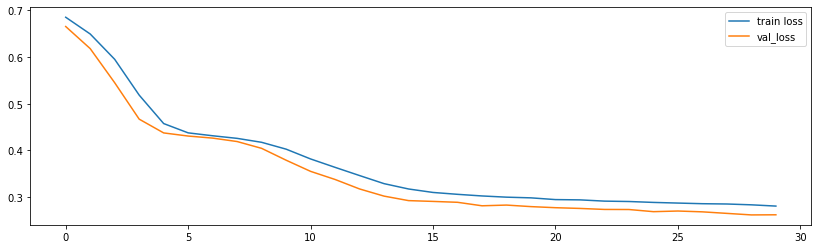

In [25]:
plt.figure(figsize = (14, 4))
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()

In [26]:
sub = pd.DataFrame()
sub['ID'] = test_id

#preds = predict_1(model.predict_proba(X_test))
sub[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']] = (model.predict(X_test)>.6).astype(int)
sub.to_csv('sub.csv', index = None)